### Generate Dataset

Before running the pipeline, make sure to **generate the dataset** file:
`artifacts/dataset.csv`

You can do this using the **Dataset Build** section in the notebook:
`phia.ipynb`

In [6]:
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
import numpy as np
from matplotlib.pyplot import pie, axis, show

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

##### Util Functions

In [71]:
def interval_by_ph(ph_value: str) -> str | None:
    ph_value = float(str(ph_value).replace("EXT", ""))
    if 2.50 <= ph_value <= 4.00:
        return "2.50 - 4.00"
    if 4.00 < ph_value <= 5.50:
        return "4.00 - 5.50"
    if 5.50 < ph_value <= 7.00:
        return "5.50 - 7.00"
    return None

def interval_to_index(interval: str) -> int | None:
    mapping = {
        "2.50 - 4.00": -1,
        "4.00 - 5.50": 0,
        "5.50 - 7.00": 1
    }
    return mapping.get(interval)

def index_to_interval(index: int) -> str | None:
    mapping = {
        -1: "2.50 - 4.00",
        0: "4.00 - 5.50",
        1: "5.50 - 7.00"
    }
    return mapping.get(index)

def evaluate_model(model, x_train, y_train, x_test, y_test, cv=5):
    # Cross-validation (no treino)
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1_weighted')

    # Treina e avalia no conjunto de teste
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return {
        'Model': model.__class__.__name__,
        'CV_F1_Mean': np.mean(cv_scores),
        'CV_F1_Std': np.std(cv_scores),
        'Accuracy_Test': accuracy_score(y_test, y_pred),
        'Precision_Test': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall_Test': recall_score(y_test, y_pred, average='weighted'),
        'F1_Test': f1_score(y_test, y_pred, average='weighted')
    }


##### Preparing dataset

In [64]:

dataset = pd.read_csv("artifacts/dataset.csv",sep=",")

## Splitting validation data (lines where label == 'Validação')
dataset_train = dataset[dataset['label'] != 'Validação'].copy()
dataset_test = dataset[dataset['label'] == 'Validação'].copy()

## Translating "label" (from validation data) to a interval based on "real_ph"
dataset_test['real_ph'] = dataset_test['real_ph'].str.replace("EXT", "", regex=False).astype(float)
dataset_test['label'] = dataset_test['real_ph'].apply(interval_by_ph)

## Dropping "strip_id" and "real_ph" columns
dataset_test.drop(['strip_id', 'real_ph'], axis=1, inplace=True)
dataset_train.drop(['strip_id', 'real_ph'], axis=1, inplace=True)

## Translating "label" to a index (based on the "label" itself)
dataset_test['label'] = dataset_test['label'].apply(interval_to_index)
dataset_train['label'] = dataset_train['label'].apply(interval_to_index)

## Splitting x and y from training data
x_train = dataset_train.drop('label', axis=1)
y_train = dataset_train['label']

print(x_train.head())
print(y_train.head())

## Splitting x and y from validation data
x_test = dataset_test.drop('label', axis=1)
y_test = dataset_test['label']

print(x_test.head())
print(y_test.head())



    Q0_R   Q0_G   Q0_B   Q1_R   Q1_G   Q1_B   Q2_R   Q2_G   Q2_B   Q3_R  \
0  249.0  198.0  120.0  213.0  184.0   99.0  252.0  235.0  203.0  252.0   
1  249.0  222.0   66.0  225.0  203.0  127.0  253.0  220.0  122.0  253.0   
2  248.0  189.0   78.0  193.0  180.0  117.0  252.0  202.0  165.0  252.0   
3  250.0  201.0   49.0  213.0  196.0  133.0  252.0  207.0  153.0  252.0   
4  247.0  196.0   86.0  205.0  189.0  126.0  252.0  210.0  169.0  251.0   

    Q3_G  Q3_B  
0  122.0  54.0  
1  159.0  79.0  
2  119.0  42.0  
3  123.0  36.0  
4  118.0  33.0  
0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64
     Q0_R   Q0_G   Q0_B   Q1_R   Q1_G   Q1_B   Q2_R   Q2_G   Q2_B   Q3_R  \
10  251.0  204.0   89.0  210.0  194.0  128.0  252.0  238.0  204.0  252.0   
11  246.0  233.0   70.0  252.0  223.0  121.0  252.0  249.0  126.0  252.0   
12  250.0  199.0   77.0  205.0  188.0  124.0  252.0  221.0  187.0  253.0   
13  244.0  214.0   56.0  226.0  203.0  126.0  252.0  218.0   70.0  252.0   
14  25

##### Training Models

In [75]:
models = [
    DecisionTreeClassifier(max_depth=4, random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(random_state=42),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, random_state=42)),
    GaussianNB()
]

results = []

for model in models:
    name = model.__class__.__name__
    if name == 'Pipeline':
        name += f" ({model.steps[-1][1].__class__.__name__})"

    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_weighted')

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    results.append({
        'Model': name,
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std(),
        'Accuracy_Test': accuracy_score(y_test, y_pred),
        'Precision_Test': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall_Test': recall_score(y_test, y_pred, average='weighted'),
        'F1_Test': f1_score(y_test, y_pred, average='weighted')
    })

df_results = pd.DataFrame(results).sort_values(by='CV_F1_Mean', ascending=False).reset_index(drop=True)
print(df_results)



                             Model  CV_F1_Mean  CV_F1_Std  Accuracy_Test  \
0           RandomForestClassifier    0.700000   0.112875       0.666667   
1                       GaussianNB    0.668889   0.094907       0.666667   
2    Pipeline (LogisticRegression)    0.595556   0.164744       0.666667   
3                   Pipeline (SVC)    0.595556   0.058626       0.666667   
4       GradientBoostingClassifier    0.571111   0.159876       0.666667   
5           DecisionTreeClassifier    0.564444   0.149137       0.666667   
6  Pipeline (KNeighborsClassifier)    0.537778   0.089055       0.666667   

   Precision_Test  Recall_Test   F1_Test  
0        0.666667     0.666667  0.666667  
1        0.666667     0.666667  0.666667  
2        0.666667     0.666667  0.666667  
3        0.666667     0.666667  0.666667  
4        0.722222     0.666667  0.655556  
5        0.833333     0.666667  0.666667  
6        0.666667     0.666667  0.666667  


##### Best models report


Best model: RandomForestClassifier


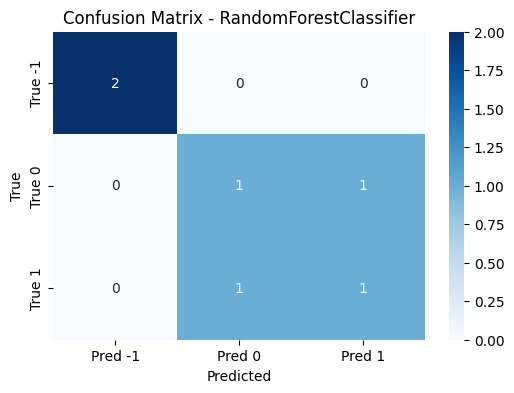


Classification Report:
              precision    recall  f1-score   support

          -1      1.000     1.000     1.000         2
           0      0.500     0.500     0.500         2
           1      0.500     0.500     0.500         2

    accuracy                          0.667         6
   macro avg      0.667     0.667     0.667         6
weighted avg      0.667     0.667     0.667         6



In [77]:
best_row = df_results.iloc[0]
best_name = best_row['Model']
print(f"\nBest model: {best_name}")

best_model = None
for m in models:
    name = m.__class__.__name__
    if name == 'Pipeline':
        name += f" ({m.steps[-1][1].__class__.__name__})"
    if name == best_name:
        best_model = m
        break

best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred -1', 'Pred 0', 'Pred 1'],
            yticklabels=['True -1', 'True 0', 'True 1'])
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
